In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack

In [ ]:
from maddeb.utils import listdir_fullpath, get_data_dir_path

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

## load the saved results

In [ ]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/high_density"
run_name = "kl01" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    madness_results[band+"_relative_flux_err"] = (madness_results[band+"_predicted_flux"]-madness_results[band+"_actual_flux"])/madness_results[band+"_actual_flux"]
    scarlet_results[band+"_relative_flux_err"] = (scarlet_results[band+"_predicted_flux"]-scarlet_results[band+"_actual_flux"])/scarlet_results[band+"_actual_flux"]

In [ ]:
scarlet_results

,u_covariance,u_actual_flux,u_predicted_flux,u_blendedness,g_covariance,g_actual_flux,g_predicted_flux,g_blendedness,r_covariance,r_actual_flux,...,z_phot_flags,y_phot_flux,y_phot_fluxerrs,y_phot_flags,u_relative_flux_err,g_relative_flux_err,r_relative_flux_err,i_relative_flux_err,z_relative_flux_err,y_relative_flux_err
0,0.997830,4174.720537,3358.822909,0.466214,0.997781,39963.497696,41422.787940,0.424744,0.997718,160378.651599,...,0,67589.956588,4790.684186,0,-0.195438,0.036516,-0.260612,-0.163743,-0.127341,-0.279217
1,0.987004,1038.079634,883.982078,0.602536,0.986378,45992.641803,38516.664532,0.249773,0.985534,100291.508781,...,0,20248.552579,4791.904276,0,-0.148445,-0.162547,-0.206863,-0.133292,0.176367,0.617732
2,0.999819,7409.172734,5466.865700,0.002585,0.999806,100889.700146,103899.724690,0.001589,0.999780,407350.040419,...,0,151557.984900,4795.562684,0,-0.262149,0.029835,-0.006389,0.020341,0.014815,-0.068132
3,0.996774,3407.119590,3661.016988,0.520547,0.996277,27409.405507,27617.577016,0.562122,0.995518,77119.662098,...,0,72021.498685,4793.124056,0,0.074520,0.007595,0.505132,0.418474,0.265547,0.575730
4,0.996463,1660.370492,1942.557906,0.000634,0.995992,15618.520226,14870.047873,0.000794,0.995278,49917.058211,...,0,19990.532360,4801.653837,0,0.169954,-0.047922,-0.020530,0.061435,-0.019353,0.104501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.872202,1741.222628,1224.953835,0.905087,0.868395,37143.754528,18345.725132,0.792568,0.863503,93716.605372,...,0,28066.113319,4778.687085,0,-0.296498,-0.506089,-0.461262,-0.147384,0.001251,0.347606
12,0.996406,25076.133221,29115.753453,0.001450,0.996062,228065.957909,253895.307658,0.001347,0.995540,636182.114618,...,0,274347.664635,4772.600359,0,0.161094,0.113254,0.093453,0.040756,0.116593,0.027411
13,0.995845,3436.316589,1439.258755,0.136048,0.995432,27887.849216,25316.113879,0.196922,0.994817,80386.633687,...,0,37833.457398,4785.980939,0,-0.581162,-0.092217,-0.000367,0.052305,-0.071539,-0.223439
14,0.992315,12417.220912,8943.848121,0.170311,0.991215,102076.348765,79739.387293,0.274324,0.989426,229708.834942,...,0,119583.588339,4784.766069,0,-0.279722,-0.218826,-0.057456,-0.159764,-0.270087,-0.290633


In [ ]:
madness_results

,u_covariance,u_actual_flux,u_predicted_flux,u_blendedness,g_covariance,g_actual_flux,g_predicted_flux,g_blendedness,r_covariance,r_actual_flux,...,z_phot_flags,y_phot_flux,y_phot_fluxerrs,y_phot_flags,u_relative_flux_err,g_relative_flux_err,r_relative_flux_err,i_relative_flux_err,z_relative_flux_err,y_relative_flux_err
0,0.995475,4174.720537,4047.744141,0.466214,0.996216,39963.497696,34076.742188,0.424744,0.995850,160378.651599,...,0,62806.563715,4790.684186,0,-0.030416,-0.147303,-0.222461,-0.330369,-0.228694,-0.183095
1,0.988747,1038.079634,3319.295410,0.602536,0.995061,45992.641803,45222.343750,0.249773,0.995936,100291.508781,...,0,22033.927037,4791.904276,0,2.197534,-0.016748,0.149672,0.250514,0.307785,0.459881
2,0.996332,7409.172734,7469.193359,0.002585,0.999574,100889.700146,96248.921875,0.001589,0.999807,407350.040419,...,0,151651.070214,4795.562684,0,0.008101,-0.045999,0.005716,-0.014501,0.003316,0.006965
3,0.991137,3407.119590,3542.604492,0.520547,0.992757,27409.405507,32158.314453,0.562122,0.992575,77119.662098,...,0,61659.855004,4793.124056,0,0.039765,0.173258,0.618484,0.600036,0.549310,0.686749
4,0.990993,1660.370492,1773.170532,0.000634,0.994034,15618.520226,15001.957031,0.000794,0.995285,49917.058211,...,0,19998.727213,4801.653837,0,0.067937,-0.039476,0.063568,-0.063887,0.138827,0.241082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.961542,1741.222628,6123.540039,0.905087,0.958927,37143.754528,80006.531250,0.792568,0.963438,93716.605372,...,0,45976.900879,4778.687085,0,2.516805,1.153970,1.089887,1.442068,1.518715,1.110009
321,0.999218,25076.133221,26142.394531,0.001450,0.999747,228065.957909,210686.031250,0.001347,0.999879,636182.114618,...,0,274391.628844,4772.600359,0,0.042521,-0.076206,0.078412,-0.070082,0.038154,0.135094
322,0.993986,3436.316589,3124.152832,0.136048,0.995582,27887.849216,24983.570312,0.196922,0.996017,80386.633687,...,0,34854.568283,4785.980939,0,-0.090843,-0.104141,0.038411,-0.074448,-0.033627,0.112047
323,0.992057,12417.220912,8387.210938,0.170311,0.991885,102076.348765,56693.289062,0.274324,0.990950,229708.834942,...,0,120278.684574,4784.766069,0,-0.324550,-0.444599,-0.392567,-0.380317,-0.333768,-0.486729


In [ ]:
actual_photometry

,u_phot_flux,u_phot_fluxerrs,u_phot_flags,g_phot_flux,g_phot_fluxerrs,g_phot_flags,r_phot_flux,r_phot_fluxerrs,r_phot_flags,i_phot_flux,...,i_phot_flags,z_phot_flux,z_phot_fluxerrs,z_phot_flags,y_phot_flux,y_phot_fluxerrs,y_phot_flags,galaxy_num,field_num,file_num
0,3622.351406,345.207084,0,32974.923587,1363.752333,0,130228.888964,3193.017683,0,207981.591958,...,0,166985.465340,4449.376025,0,91411.336905,4790.684186,0,0,0,0
1,632.683715,345.295002,0,26376.203882,1364.099653,0,56728.303554,3193.830880,0,41860.634944,...,0,39158.007824,4450.509191,0,21608.880100,4791.904276,0,1,0,0
2,4914.642664,345.558619,0,73678.860334,1365.141083,0,303876.330986,3196.269229,0,372439.734827,...,0,284787.244431,4453.906959,0,151564.490801,4795.562684,0,2,0,0
3,3189.775689,345.382896,0,23591.468842,1364.446885,0,65570.122929,3194.643870,0,90705.572338,...,0,86435.663885,4451.642069,0,47112.618171,4793.124056,0,3,0,0
4,1621.880220,345.997535,0,10080.652876,1366.875037,0,36697.649686,3200.329016,0,51696.656947,...,0,40812.709199,4459.564153,0,19988.485540,4801.653837,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,750.561609,348.973824,0,18425.170109,1371.865842,0,46730.002044,3139.501104,0,34010.811844,...,0,11401.098613,4385.615701,0,14617.198283,4778.687085,0,11,304,4784
321,16351.091118,348.529328,0,155894.005532,1370.118464,0,454622.210386,3135.502248,0,657651.487539,...,0,515448.027754,4380.029639,0,274126.764098,4772.600359,0,12,304,4784
322,1962.137546,349.506473,0,19014.544652,1373.959762,0,56205.534014,3144.293019,0,82369.496489,...,0,67979.306078,4392.309598,0,35963.131409,4785.980939,0,13,304,4784
323,6882.448101,349.417755,0,58394.002472,1373.610997,0,137713.688690,3143.494874,0,178094.490639,...,0,151593.004159,4391.194657,0,127316.459344,4784.766069,0,14,304,4784


# Pixel Covariance

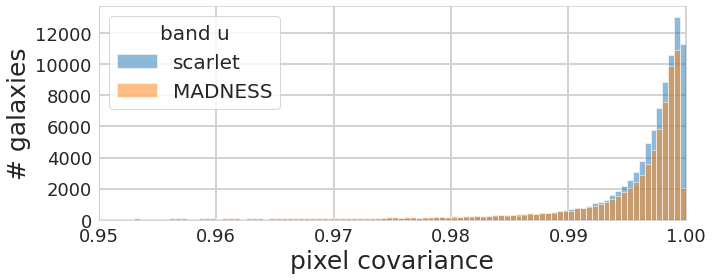

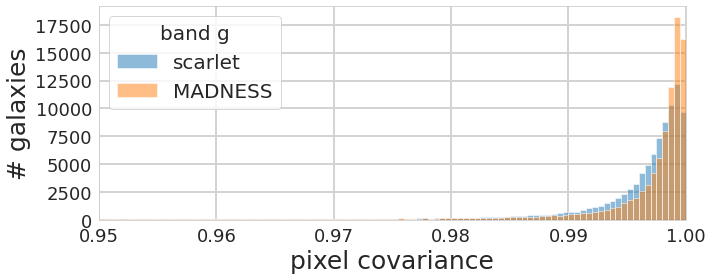

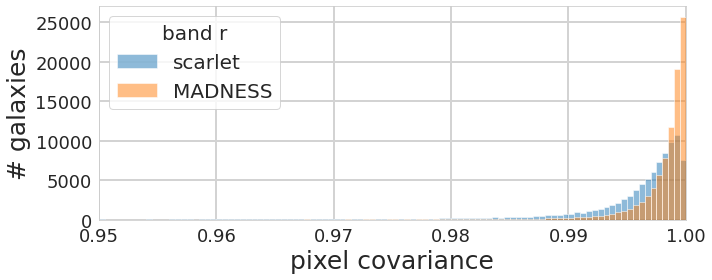

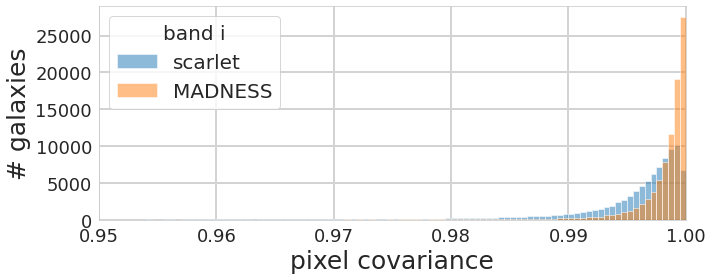

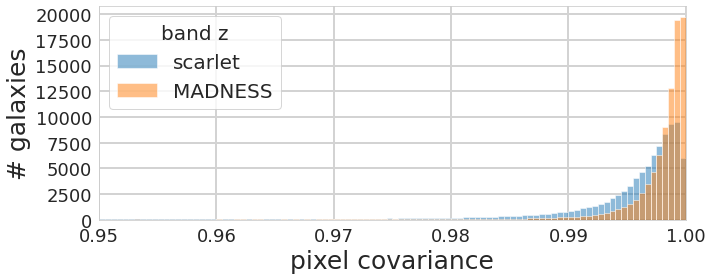

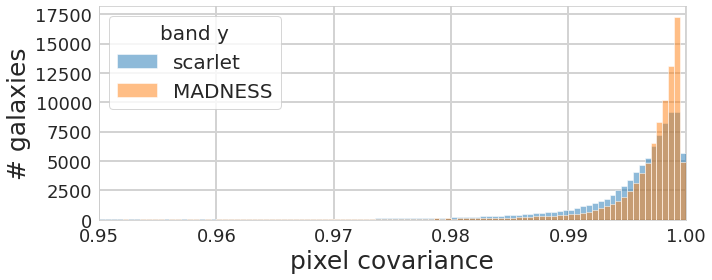

In [ ]:
bins = np.arange(0.95, 1, 0.0005)
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    plt.figure(figsize=(10, 4))
    cov_band = band
    sns.set_style("whitegrid")
    plt.hist(scarlet_results[cov_band + '_covariance'], bins=bins, alpha=0.5, label="scarlet")
    plt.hist(madness_results[cov_band + '_covariance'], bins=bins, alpha=0.5, label="MADNESS")
    plt.legend()
    plt.xlim([0.95, 1])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("pixel covariance", fontsize=25)
    plt.ylabel("# galaxies", fontsize=25)
    plt.legend(fontsize=20, title="band " + band, loc="upper left", title_fontsize=20)
    ax = plt.gca()
    ax.grid(color='lightgray', linestyle='-', linewidth=2)
    plt.tight_layout()
    plt.savefig(result_dir_path + "/cov_res_"+band)
    plt.show()

# Plot the relative flux error

In [ ]:
def gauss(x, sig, mu, a):
    return np.exp(-(x-mu)**2/(2*sig**2))/(np.sqrt(2*np.pi)*sig)

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: 10.475425440738567
Madness sig: 12.838659499869934
Scarlet mu: -0.11262392276901224
Scarlet sig: 0.8767523251314887


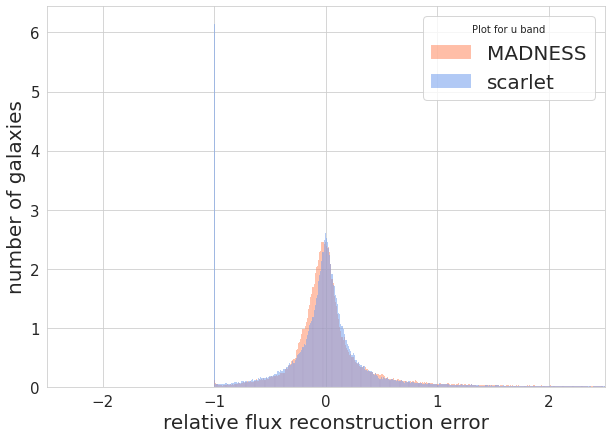

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: 1.1149330836595086
Madness sig: 2.3355325516759153
Scarlet mu: -0.3919125027943394
Scarlet sig: 0.5575856860563279


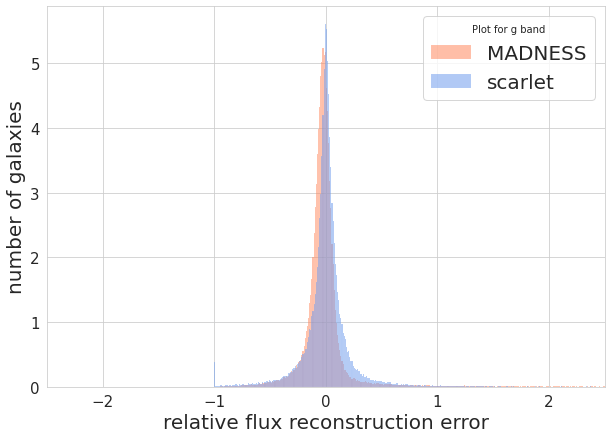

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: -0.4057268154836843
Madness sig: 0.5547326588109528
Scarlet mu: -0.42908259970762747
Scarlet sig: 0.5153638146082317


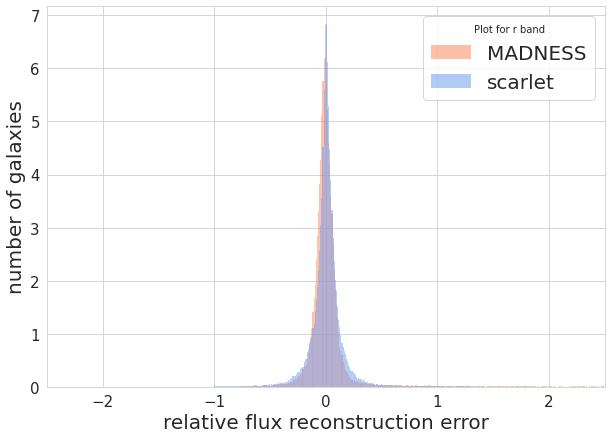

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: -0.4464684251105053
Madness sig: 0.4901276342088616
Scarlet mu: 0.11514054785220314
Scarlet sig: 0.32271017914600614


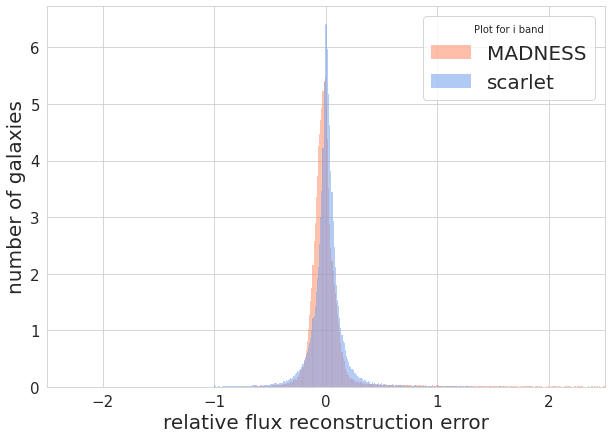

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: -0.3624186124139703
Madness sig: 0.5929075059153176
Scarlet mu: 0.03571032678953626
Scarlet sig: 0.2726034403429943


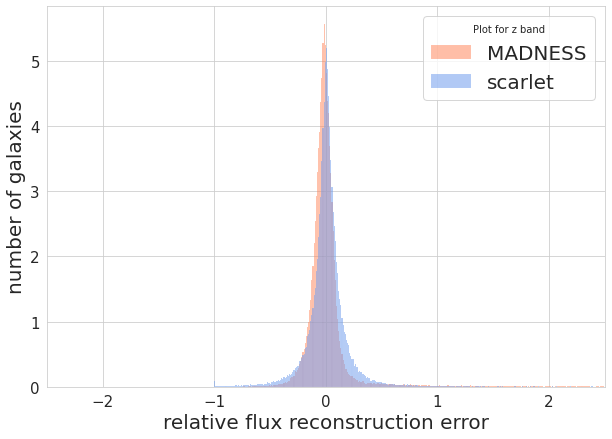

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: -0.27413231141910105
Madness sig: 0.6897681624777914
Scarlet mu: 0.04368158318213203
Scarlet sig: 0.3269366747698347


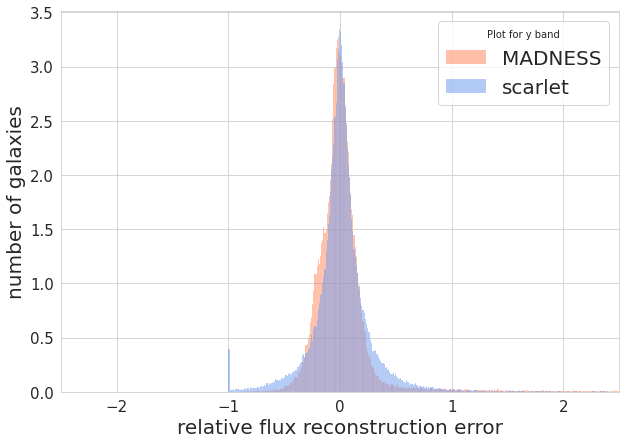

In [ ]:
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):

    madness_actual_flux = madness_results[band+"_actual_flux"].values
    madness_predicted_flux = madness_results[band+"_predicted_flux"].values

    scarlet_actual_flux = scarlet_results[band+"_actual_flux"].values
    scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].values

    scarlet_relative_difference = np.divide(
        scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
    )
    madness_relative_difference = np.divide(
        madness_predicted_flux - madness_actual_flux, madness_actual_flux
    )
    
    n_bins = 1000

    hist, bin_tmp = np.histogram(madness_relative_difference, n_bins, density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])

    hist, bin_tmp = np.histogram(scarlet_relative_difference, n_bins, density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])
    
#     sns.set_theme(style={"axes.grid": True,
#                      'axes.labelcolor': 'black',
#                      'figure.facecolor': '1.',
#                      'xtick.color': 'black',
#                      'ytick.color': 'black',
#                      'text.color': 'black',
#                      'image.cmap': 'viridis',})
    plt.figure(figsize=(10, 7))
    bins = np.arange(-5, 5, 0.01)
    sns.histplot(
        x = madness_relative_difference[
            np.logical_not(np.isnan(madness_relative_difference))
        ].reshape(-1),
        bins=bins,
        kde=False,
        alpha=0.5,
        stat="density",
        color="coral",
        label="MADNESS",
    )
#     plt.plot(bins, gauss(bins, *madness_fit[0]), color="coral")
    LOG.info("Madness mu: " + str(madness_fit[0][1]))
    LOG.info("Madness sig: " + str(madness_fit[0][0]))
    sns.histplot(
        x = scarlet_relative_difference[
            np.logical_not(np.isnan(scarlet_relative_difference))
        ].reshape(-1),
        bins=bins,
        kde=False,
        alpha=0.5,
        stat="density",
        color="cornflowerblue",
        label="scarlet",
    )
#     plt.plot(
#         bins, gauss(bins, scarlet_fit[0][0], scarlet_fit[0][1], scarlet_fit[0][2]), color="cornflowerblue"
#     )
    LOG.info("Scarlet mu: " + str(scarlet_fit[0][1]))
    LOG.info("Scarlet sig: " + str(scarlet_fit[0][0]))
    plt.legend(fontsize=20, title = "Plot for " + band + " band")
    ax = plt.gca()
    plt.xlabel("relative flux reconstruction error", fontsize=20)
    ax.tick_params(labelsize=15)
    plt.ylabel("number of galaxies", fontsize=20)
    plt.xlim([-2.5, 2.5])
    plt.show()

# Compare apperture photometry

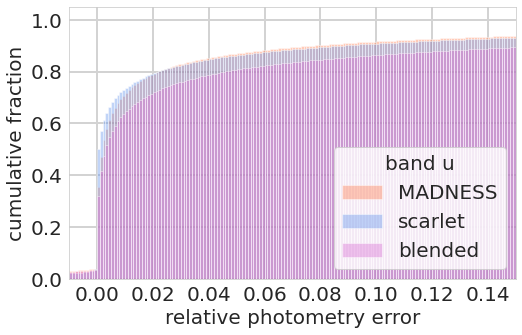

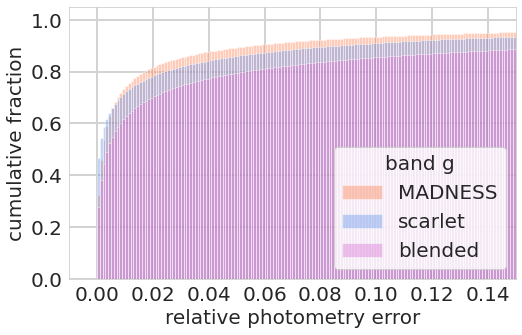

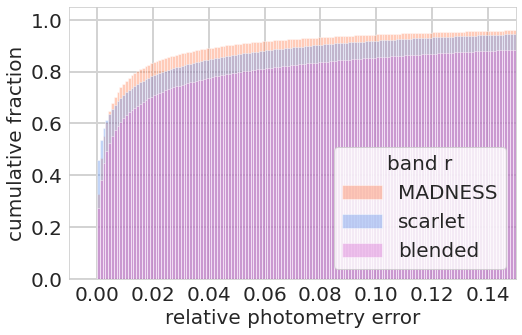

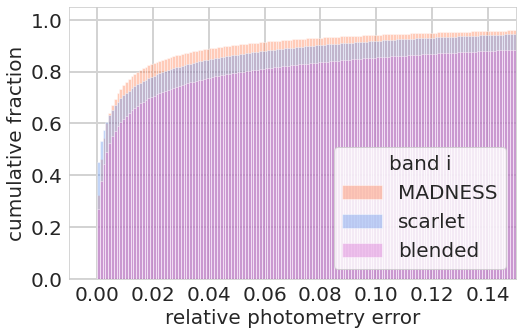

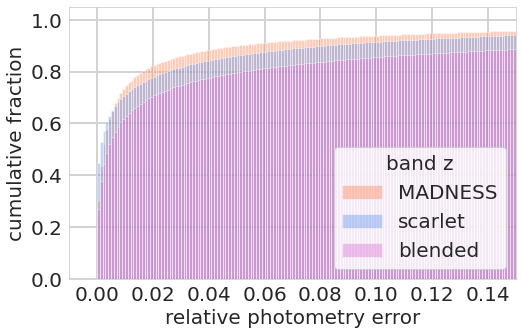

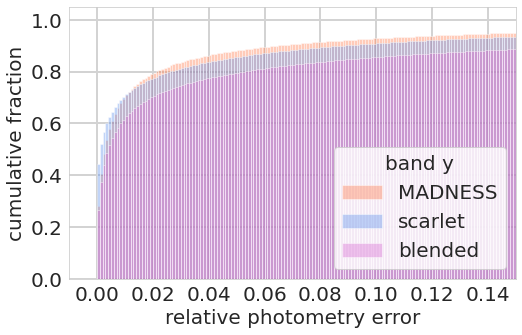

In [ ]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("whitegrid")
#     sns.set_theme(style={"axes.grid": True,'grid.color': 'black',
# })
    plt.figure(figsize=(8, 5))
    bins = np.arange(-1, 1, 0.001)
    plt.hist(
        np.abs((madness_results[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values)) / actual_photometry[band+"_phot_flux"].values,
        bins=bins,
        alpha=0.4,
        density=True,
        label="MADNESS",
        cumulative=True,
        color="coral"
    )

    plt.hist(
        np.abs((scarlet_results[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values)) / actual_photometry[band+"_phot_flux"].values,
        bins=bins,
        density=True,
        alpha=0.4,
        label="scarlet",
        cumulative=True,
        color="cornflowerblue"
    )

    plt.hist(
        (blended_photometry[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values,
        bins=bins,
        alpha=0.4,
        density=True,
        label="blended",
        cumulative=True,
        color="orchid",
    )
    ax = plt.gca()
    ax.grid(color='lightgray', linestyle='-', linewidth=2)
    plt.xlim([-.01, .15])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("relative photometry error", fontsize=20)
    plt.ylabel("cumulative fraction", fontsize=20)
    plt.legend(fontsize=20, title="band " + band, loc="lower right", title_fontsize=20)
    plt.savefig(result_dir_path + "/cumulative_distib_phot_err_"+band)
    plt.show()

# error variation plots

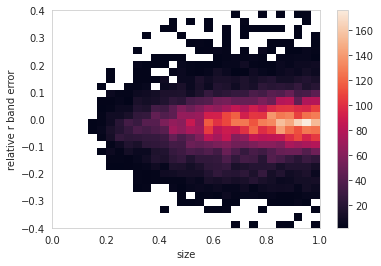

In [ ]:
h = plt.hist2d(madness_results['size'].values, madness_results["r_relative_flux_err"], range=[[0, 1], [-.4,.4]], bins=30, cmin=2)
plt.xlabel("size")
plt.ylabel("relative r band error")
plt.colorbar(h[3])
#plt.ylim(-.1,.1)

# Plot SNR

Note that the SNR definition here is not the same as the one used to place cuts on the catalog.

u


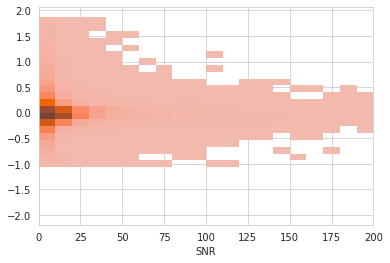

g


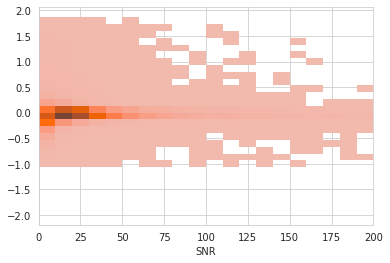

r


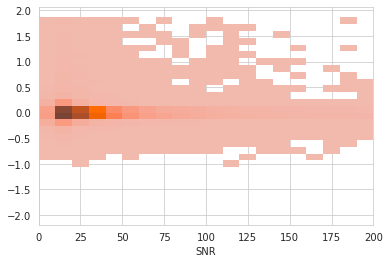

i


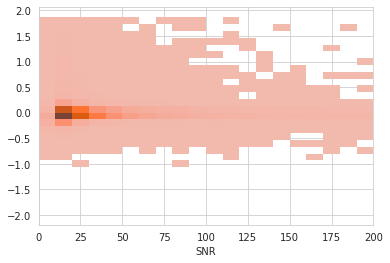

z


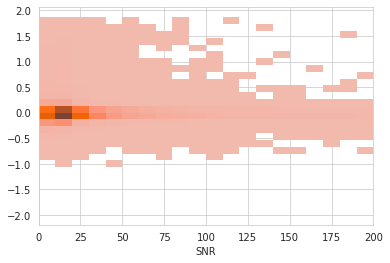

y


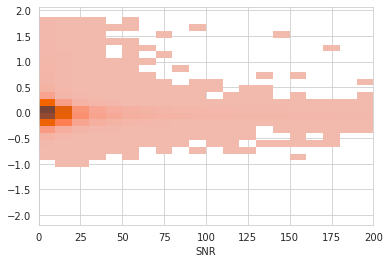

In [ ]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    snr = actual_photometry[band+"_phot_flux"].values / actual_photometry[band+"_phot_fluxerrs"].values
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = np.arange(0,1000,1000/100.0)
    y_bins = np.arange(-2, 2, 4/30.0)
    print(band)
    sns.histplot(x=snr, y=madness_results[band + "_relative_flux_err"].values, bins=[x_bins, y_bins], kde=True, color='coral')
    plt.xlim(0,200)
    plt.xlabel("SNR")
    
    plt.show()

# Validate SNR vs mag 

Note that this is not the SNR definition used for making the cut

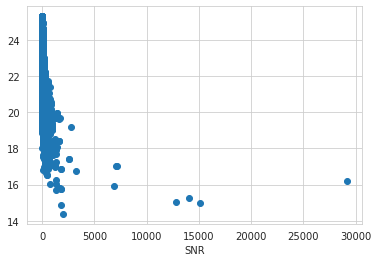

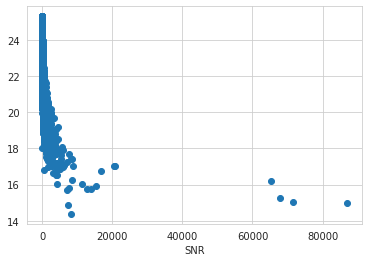

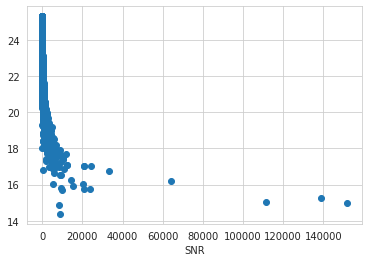

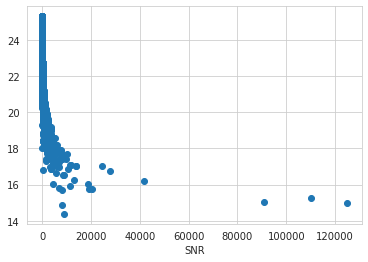

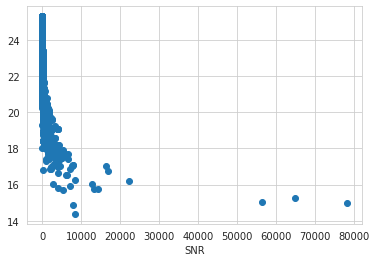

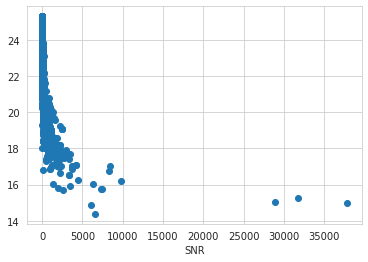

In [ ]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    snr = actual_photometry[band+"_phot_flux"] / actual_photometry[band+"_phot_fluxerrs"]
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = [-200, 1000]
    y_bins = [-2, 2]
    plt.scatter(x=snr, y=madness_results["ref_mag"])
    #sns.kdeplot(x=snr, y=scarlet_results[band+ "_relative_flux_err"], clip=[x_bins, y_bins], fill=False, alpha=0.7, label="scarlet")
    plt.xlabel("SNR")
    plt.show()

Plot for u band


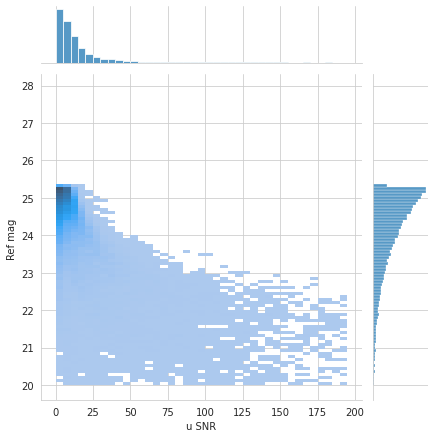

Plot for g band


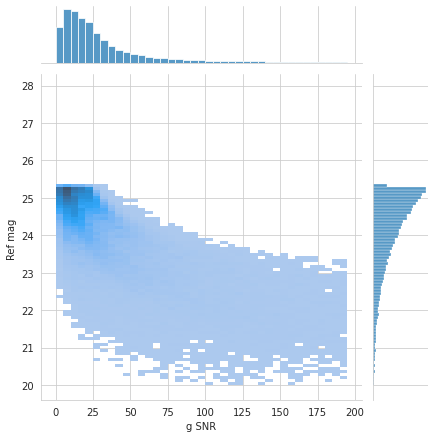

Plot for r band


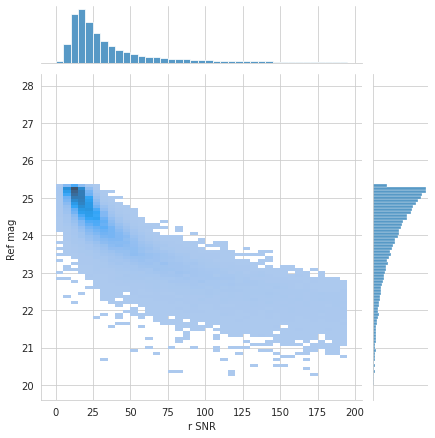

Plot for i band


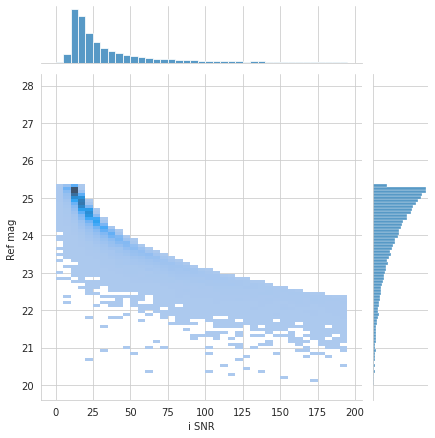

Plot for z band


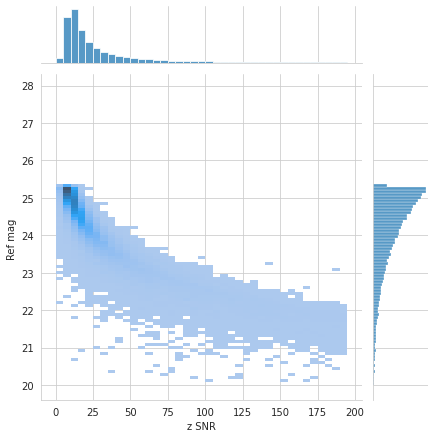

Plot for y band


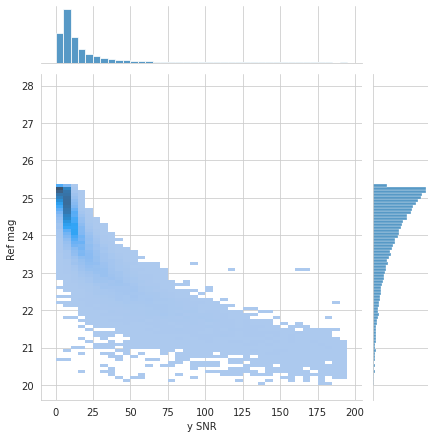

In [ ]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    print(f"Plot for {band} band")
    snr = actual_photometry[band+"_phot_flux"].values / actual_photometry[band+"_phot_fluxerrs"].values
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = np.arange(0,200,5.0)
    y_bins = np.arange(20, 28, 8/100.0)
    #sns.histplot(x=snr, y=madness_results["ref_mag"], bins=[x_bins, y_bins], kde=False, cbar=True)
    g = sns.JointGrid()
    sns.histplot(x=snr, y=madness_results["ref_mag"].values, bins=[x_bins, y_bins], kde=False, ax=g.ax_joint)
    g.ax_joint.set_xlabel(band + " SNR")
    g.ax_joint.set_ylabel("Ref mag ")
    sns.histplot(x=snr, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,500)})
    sns.histplot(y=madness_results["ref_mag"].values, ax=g.ax_marg_y, bins=y_bins)
    #ax.set(xlabel='SNR', ylabel='Ref Mag '+band)
    
    plt.show()

In [ ]:
snr = actual_photometry["r_phot_flux"].values / actual_photometry["r_phot_fluxerrs"].values
madness_results["snr"] = snr
#h = plt.hist2d(snr, madness_results[band+ "_relati"ve_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
scarlet_results["snr"] = snr

# Box plots

SNR definition here is one used to place the SNR>10 cut on the catalog.

In [ ]:
boxplot_snr_df = {}

# madness_actual_flux = madness_results[band+"_actual_flux"].value
# madness_predicted_flux = madness_results[band+"_predicted_flux"].value

# scarlet_actual_flux = scarlet_results[band+"_actual_flux"].value
# scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].value

# scarlet_relative_difference = np.divide(
#     scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
# )
# madness_relative_difference = np.divide(
#     madness_predicted_flux - madness_actual_flux, madness_actual_flux
# )
boxplot_snr_df["snr"] = list(madness_results['r_band_snr'])
boxplot_snr_df["type"] = ["madness"] * len(madness_results['size'])
#boxplot_snr_df["r_relative_flux_err"] = list(madness_relative_difference)
boxplot_snr_df["r_relative_flux_err"] = list(np.abs((madness_results["r_phot_flux"].values - actual_photometry["r_phot_flux"].values)) / actual_photometry["r_phot_flux"].values)


boxplot_snr_df["snr"].extend(list(scarlet_results['snr']))
boxplot_snr_df["type"].extend(["scarlet"] * len(scarlet_results['size']))
boxplot_snr_df["r_relative_flux_err"].extend(list(np.abs((scarlet_results["r_phot_flux"].values - actual_photometry["r_phot_flux"].values)) / actual_photometry["r_phot_flux"].values)) 

boxplot_snr_df = pd.DataFrame(boxplot_snr_df)

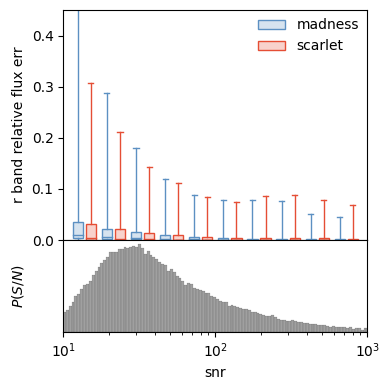

In [ ]:
import maddeb.boxplot
import matplotlib as mpl

fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_snr_df, 
    x = 'snr', y = "r_relative_flux_err", z = "type",
    xlim = (10, 1000),
    ylim = (-0, 0.45), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label='Signal to noise ratio S/N', 
    y_label = 'r band relative flux err',
    y_label_hist='$P(S/N)$',
    legend_remove = False,
    whis = [5,95],
    percents = [25,75],
    palette = mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10
)

In [ ]:
import scipy
scipy.stats.norm.cdf(-2)

0.022750131948179195

In [ ]:
madness_results

,u_covariance,u_actual_flux,u_predicted_flux,u_blendedness,g_covariance,g_actual_flux,g_predicted_flux,g_blendedness,r_covariance,r_actual_flux,...,y_phot_flux,y_phot_fluxerrs,y_phot_flags,u_relative_flux_err,g_relative_flux_err,r_relative_flux_err,i_relative_flux_err,z_relative_flux_err,y_relative_flux_err,snr
0,0.995475,4174.720537,4047.744141,0.466214,0.996216,39963.497696,34076.742188,0.424744,0.995850,160378.651599,...,62806.563715,4790.684186,0,-0.030416,-0.147303,-0.222461,-0.330369,-0.228694,-0.183095,40.785521
1,0.988747,1038.079634,3319.295410,0.602536,0.995061,45992.641803,45222.343750,0.249773,0.995936,100291.508781,...,22033.927037,4791.904276,0,2.197534,-0.016748,0.149672,0.250514,0.307785,0.459881,17.761837
2,0.996332,7409.172734,7469.193359,0.002585,0.999574,100889.700146,96248.921875,0.001589,0.999807,407350.040419,...,151651.070214,4795.562684,0,0.008101,-0.045999,0.005716,-0.014501,0.003316,0.006965,95.072195
3,0.991137,3407.119590,3542.604492,0.520547,0.992757,27409.405507,32158.314453,0.562122,0.992575,77119.662098,...,61659.855004,4793.124056,0,0.039765,0.173258,0.618484,0.600036,0.549310,0.686749,20.525018
4,0.990993,1660.370492,1773.170532,0.000634,0.994034,15618.520226,15001.957031,0.000794,0.995285,49917.058211,...,19998.727213,4801.653837,0,0.067937,-0.039476,0.063568,-0.063887,0.138827,0.241082,11.466837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.961542,1741.222628,6123.540039,0.905087,0.958927,37143.754528,80006.531250,0.792568,0.963438,93716.605372,...,45976.900879,4778.687085,0,2.516805,1.153970,1.089887,1.442068,1.518715,1.110009,14.884531
321,0.999218,25076.133221,26142.394531,0.001450,0.999747,228065.957909,210686.031250,0.001347,0.999879,636182.114618,...,274391.628844,4772.600359,0,0.042521,-0.076206,0.078412,-0.070082,0.038154,0.135094,144.991830
322,0.993986,3436.316589,3124.152832,0.136048,0.995582,27887.849216,24983.570312,0.196922,0.996017,80386.633687,...,34854.568283,4785.980939,0,-0.090843,-0.104141,0.038411,-0.074448,-0.033627,0.112047,17.875412
323,0.992057,12417.220912,8387.210938,0.170311,0.991885,102076.348765,56693.289062,0.274324,0.990950,229708.834942,...,120278.684574,4784.766069,0,-0.324550,-0.444599,-0.392567,-0.380317,-0.333768,-0.486729,43.809102


In [ ]:
boxplot_blendedness_df = {}

boxplot_blendedness_df['r_blendedness'] = list(madness_results['r_blendedness'])
boxplot_blendedness_df["type"] = ["madness"] * len(madness_results['size'])
boxplot_blendedness_df["r_relative_flux_err"] = list(np.abs((madness_results["r_phot_flux"].values - actual_photometry["r_phot_flux"].values)) / actual_photometry["r_phot_flux"].values)


boxplot_blendedness_df['r_blendedness'].extend(list(scarlet_results['r_blendedness']))
boxplot_blendedness_df["type"].extend(["scarlet"] * len(scarlet_results['size']))
boxplot_blendedness_df["r_relative_flux_err"].extend(list(np.abs((scarlet_results["r_phot_flux"].values - actual_photometry["r_phot_flux"].values)) / actual_photometry["r_phot_flux"].values)) 

boxplot_blendedness_df = pd.DataFrame(boxplot_blendedness_df)

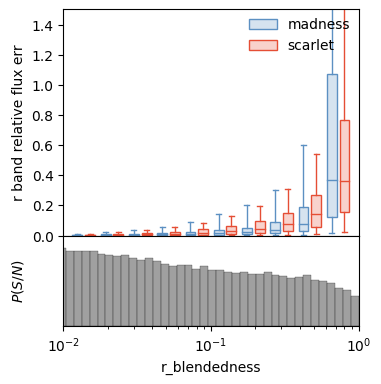

In [ ]:
import maddeb.boxplot
import matplotlib as mpl

fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_blendedness_df, 
    x = 'r_blendedness', y = "r_relative_flux_err", z = "type",
    xlim = (.01, 1),
    ylim = (-0, 1.5), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label='Signal to noise ratio S/N', 
    y_label = 'r band relative flux err',
    y_label_hist='$P(S/N)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)

In [ ]:
snr_blendedness_df = {}
snr_blendedness_df["snr"] = madness_results['r_band_snr']
snr_blendedness_df["blendedness"] = madness_results['r_blendedness']


<AxesSubplot:>

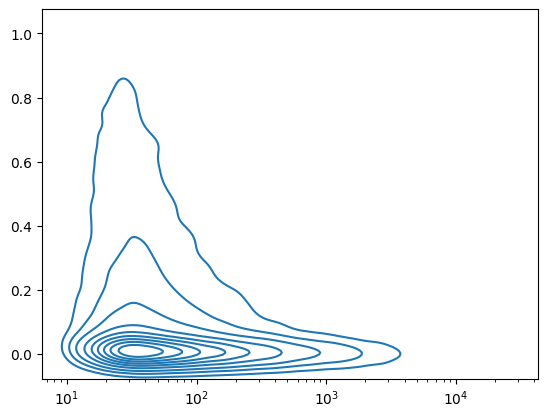

In [ ]:
sns.kdeplot(x=madness_results['r_band_snr'].values, y=madness_results['r_blendedness'].values, log_scale=[True, False])

<AxesSubplot:xlabel='Count'>

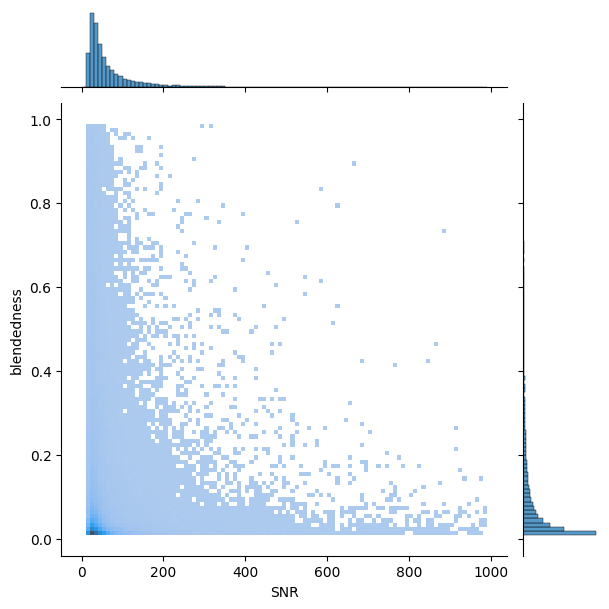

In [ ]:
g = sns.JointGrid()
x_bins = np.arange(0,1000,10)
y_bins = np.arange(0.01, 1, .01)
sns.histplot(x=madness_results['r_band_snr'].values, y=madness_results['r_blendedness'].values, ax=g.ax_joint, bins=[x_bins, y_bins], log_scale=[False, False])
g.ax_joint.set_xlabel("SNR")
g.ax_joint.set_ylabel("blendedness")
sns.histplot(x=madness_results['r_band_snr'].values, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,1000)})
sns.histplot(y=madness_results['r_blendedness'].values, ax=g.ax_marg_y, bins=y_bins)